### Tworzenie środowiska wirtualnego i jego aktywacja (opcjonalne)

In [1]:
#!python3 -m venv .env
#!source .env/bin/activate 

### Źródło danych oraz potrzebne referencje

> https://doi.org/10.1016/j.dib.2019.104863

W poniższym przykładzie dane zostałe zapisane w tej samej lokalizacji, w której znajduje się skrypt w folderze 'dataset'.

### Przed przystąpieniem do pisania kodu pamiętaj o zainstalowaniu potrzebnych paczek np. przez menedżer zależności PIP

> pip install torch torchvision matplotlib tqdm scikit-learn

# Kod

### Budujemy klasę zarządzającą danymi

In [2]:
from torch.utils.data import Dataset
from PIL import Image
import os

# Klasa definiująca kolekcję składającą się z: obrazu, maski i typu nowotworu
# dziedziczy po klasie Dataset z modułu PyTorch
class BUSIDataset(Dataset):
    def __init__(self, root_dir, transform=None, augment=False):
        self.root_dir = root_dir
        self.transform = transform
        self.augment = augment
        self.image_paths = []
        self.mask_paths = []
        self.labels = []

        # Przypisujemy etykiety do klas
        class_to_label = {'normal': 0, 'benign': 1, 'malignant': 2}

        # Iteracja przez foldery "normal", "benign" i "malignant"
        for class_name in ['normal', 'benign', 'malignant']:      # -> dla każdej klasy nowotworu:
            class_dir = os.path.join(root_dir, class_name)        # -> tworzymy ścieżkę dla bieżącego typu w iteracji
            label = class_to_label[class_name]                    # -> zapisujemy klasę nowotworu (label)
                                                                  # -> i iterujemy się po wszystkich plikach, a
            for file_name in os.listdir(class_dir):               # -> dla każdego pliku znalezionego w danym folderze:
                if 'mask' not in file_name:                       # -> Ignorujemy maski przy wczytywaniu obrazów
                    img_path = os.path.join(class_dir, file_name) # -> Zapisujemy ścieżkę do obrazu
                    mask_path = os.path.join(class_dir, file_name.replace(".png", "_mask.png")) # -> Zapisujemy ścieżkę do maski
                    
                    # Dodajemy tylko istniejące maski
                    if os.path.exists(mask_path):
                        self.image_paths.append(img_path)
                        self.mask_paths.append(mask_path)
                        self.labels.append(label)

    def __len__(self): # własna definicja długości kolekcji jako ilość plików obrazów
        return len(self.image_paths)

    def __getitem__(self, idx): # własna definicja pobrania obiektu z kolekcji
        image = Image.open(self.image_paths[idx]).convert("L")
        mask = Image.open(self.mask_paths[idx]).convert("L")

        # Augmentacja
        if self.augment:
            image, mask = self.augment(image, mask)
            
        # Transformacja
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        # Zwracamy obraz, maskę i etykietę klasy
        return image, mask, self.labels[idx]

### Definujemy klasę opisującą architekturę sieci UNet

In [3]:
import torch
import torch.nn as nn
from torch.nn import functional as F

class UNet(nn.Module):
    def __init__(self, device):
        super(UNet, self).__init__()
        self.device = device
        
        # Definiowanie bloku konwolucyjnego
        def conv_block(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.ReLU(inplace=True)
            )
        
        self.dropout = nn.Dropout2d(p=0.2)

        # Bloki UNet
        self.encoder1 = conv_block(1, 32).to(device=self.device).to(torch.float32)
        self.encoder2 = conv_block(32, 64).to(device=self.device).to(torch.float32)
        self.encoder3 = conv_block(64, 128).to(device=self.device).to(torch.float32)
        self.encoder4 = conv_block(128, 256).to(device=self.device).to(torch.float32)
        
        self.center = conv_block(256, 512).to(device=self.device).to(torch.float32)
        
        self.decoder4 = conv_block(256 + 256, 256).to(device=self.device).to(torch.float32)
        self.decoder3 = conv_block(128 + 128, 128).to(device=self.device).to(torch.float32)
        self.decoder2 = conv_block(64 + 64, 64).to(device=self.device).to(torch.float32)
        self.decoder1 = conv_block(32 + 32, 32).to(device=self.device).to(torch.float32)

        self.pool = nn.MaxPool2d(kernel_size=2).to(device=self.device).to(torch.float32)
        self.final_conv = nn.Conv2d(32, 1, kernel_size=1).to(device=self.device).to(torch.float32)

    def forward(self, x):
        e1 = self.encoder1(x)
        e1 = self.dropout(e1)
        e1_pooled = self.pool(e1)

        e2 = self.encoder2(e1_pooled)
        e2 = self.dropout(e2)
        e2_pooled = self.pool(e2)
        
        e3 = self.encoder3(e2_pooled)
        e3 = self.dropout(e3)
        e3_pooled = self.pool(e3)
        
        e4 = self.encoder4(e3_pooled)
        e4 = self.dropout(e4)
        e4_pooled = self.pool(e4)

        center_bridge = self.center(e4_pooled)

        center_bridge_upsampler = nn.ConvTranspose2d(center_bridge.shape[1], center_bridge.shape[1] // 2, kernel_size=2, stride=2).to(device=self.device).to(torch.float32)
        center_bridge_unsampled = center_bridge_upsampler(center_bridge)

        # Dopasowanie rozmiaru warstwy dekodera do warstwy enkodera, aby podczas zaokrąglania nie doszło do pomyłki
        center_bridge_sized = F.interpolate(center_bridge_unsampled, size=(e4.size(2), e4.size(3)), mode='bilinear', align_corners=False)
        d4_input = torch.cat([center_bridge_sized, e4], dim=1).to(device=self.device).to(torch.float32)
        d4 = self.decoder4(d4_input)

        d4_upsampler = nn.ConvTranspose2d(d4.shape[1], d4.shape[1] // 2, kernel_size=2, stride=2).to(device=self.device).to(torch.float32)
        upsampled_d4 = d4_upsampler(d4)
        # Dopasowanie rozmiaru warstwy dekodera do warstwy enkodera, aby podczas zaokrąglania nie doszło do pomyłki
        upsampled_d4 = F.interpolate(upsampled_d4, size=(e3.size(2), e3.size(3)), mode='bilinear', align_corners=False)
        d3_input = torch.cat([upsampled_d4, e3], dim=1)
        d3 = self.decoder3(d3_input)

        d3_upsampler = nn.ConvTranspose2d(d3.shape[1], d3.shape[1] // 2, kernel_size=2, stride=2).to(device=self.device).to(torch.float32)
        upsampled_d3 = d3_upsampler(d3)
        # Dopasowanie rozmiaru warstwy dekodera do warstwy enkodera, aby podczas zaokrąglania nie doszło do pomyłki
        upsampled_d3 = F.interpolate(upsampled_d3, size=(e2.size(2), e2.size(3)), mode='bilinear', align_corners=False)
        d2_input = torch.cat([upsampled_d3, e2], dim=1)
        d2 = self.decoder2(d2_input)

        d2_upsampler = nn.ConvTranspose2d(d2.shape[1], d2.shape[1] // 2, kernel_size=2, stride=2).to(device=self.device).to(torch.float32)
        upsampled_d2 = d2_upsampler(d2)
        # Dopasowanie rozmiaru warstwy dekodera do warstwy enkodera, aby podczas zaokrąglania nie doszło do pomyłki
        upsampled_d2 = F.interpolate(upsampled_d2, size=(e1.size(2), e1.size(3)), mode='bilinear', align_corners=False)
        d1_input = torch.cat([upsampled_d2, e1], dim=1)
        d1 = self.decoder1(d1_input)

        return self.final_conv(d1)

### Funkcja pomocniczna do prezentacji danych podczas treningu

In [4]:
import matplotlib.pyplot as plt

# Funkcja do wyświetlania obrazów
def visualize_predictions(model, data_loader, device, epoch):
    model.eval()  # Przełączamy model w tryb ewaluacji
    with torch.no_grad():
        for images, masks, _ in data_loader:
            # Pobierz jeden batch z loadera
            images, masks = images.to(device).to(torch.float32), masks.to(device).to(torch.float32)
            
            # Przewidywanie maski przez model
            predicted_masks = model(images)
            
            # Konwersja tensora na NumPy dla wizualizacji
            input_image = images[0].cpu().permute(1, 2, 0).numpy()  # Przekształcamy na HWC
            true_mask = masks[0].cpu().squeeze().numpy()  # Maska referencyjna
            pred_mask = predicted_masks[0].cpu().squeeze().numpy()  # Maska przewidywana skopiowana do CPU

            # Progowanie do wartości binarnych (np. próg 0.5)
            # pred_binary_mask = (pred_mask > 0.5).astype(np.float32)
            
            # Tworzenie wykresów
            plt.figure(figsize=(12, 4))
            plt.subplot(1, 3, 1)
            plt.imshow(input_image, cmap="gray")
            plt.title("Oryginalny obraz")
            plt.axis("off")
            
            plt.subplot(1, 3, 2)
            plt.imshow(true_mask, cmap="gray")
            plt.title("Maska referencyjna")
            plt.axis("off")

            plt.subplot(1, 3, 3)
            plt.imshow(pred_mask, cmap='gray')
            plt.colorbar()
            plt.title("Raw Predicted Mask")
            plt.show()
            
            # Wyświetlanie wyników
            plt.suptitle(f"Epoka: {epoch}")
            plt.show()
            
            break  # Wyświetlamy tylko pierwszy batch z każdej epoki

### Funkcja treningu i walidacji (inferencji) modelu

In [5]:
from tqdm import tqdm
import torch

def train_one_epoch(model, data_loader, optimizer, criterion, device):
    model.train()
    epoch_loss = 0.0

    model = model.to(device).float()
    
    # Inicjalizacja paska postępu
    progress_bar = tqdm(data_loader, desc="Trening", leave=True, position=0)
    
    for batch in progress_bar:
        # Wczytaj batch
        images, masks, _ = batch
        images = images.to(device).to(torch.float32)
        masks = masks.to(device).to(torch.float32)

        # Resetuj gradienty
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)
        
        # Oblicz stratę
        loss = criterion(outputs, masks)
        epoch_loss += loss.item()
        
        # Backward pass i optymalizacja
        loss.backward()
        optimizer.step()
        
        # Aktualizuj pasek postępu
        progress_bar.set_postfix({"Strata": loss.item()})
    
    return epoch_loss / len(data_loader)

def validate_one_epoch(model, data_loader, criterion, device):
    model.eval()
    epoch_loss = 0.0
    
    # Inicjalizacja paska postępu
    progress_bar = tqdm(data_loader, desc="Walidacja", leave=True, position=0)
    
    with torch.no_grad():
        for batch in progress_bar:
            images, masks, _ = batch
            images, masks = images.to(device), masks.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, masks)
            epoch_loss += loss.item()
            
            # Aktualizuj pasek postępu
            progress_bar.set_postfix({"Strata": loss.item()})
    
    return epoch_loss / len(data_loader)

### Klasa pomocnicza do augmentacji obrazów

In [6]:
import random

# Augmentacje dla obrazów i masek
class Augmentation:
    def __init__(self, rotation=15, scale=(0.9, 1.1), flip_prob=0.5):
        self.rotation = rotation
        self.scale = scale
        self.flip_prob = flip_prob

    def __call__(self, image, mask):
        # Losowy obrót
        angle = random.uniform(-self.rotation, self.rotation)
        image = F.rotate(image, angle)
        mask = F.rotate(mask, angle)

        # Losowe skalowanie
        scale_factor = random.uniform(self.scale[0], self.scale[1])
        new_size = [int(image.size[1] * scale_factor), int(image.size[0] * scale_factor)]
        image = F.resize(image, new_size)
        mask = F.resize(mask, new_size)

        # Losowe odbicie poziome
        if random.random() < self.flip_prob:
            image = F.hflip(image)
            mask = F.hflip(mask)

        return image, mask

### Funkcje do zapisu i załadowania naszego modelu w przypadku długiego treningu

In [7]:
def save_checkpoint(model, optimizer, episode, filename="model_checkpoint.pth"):
    checkpoint = {
        'episode': episode,  # Numer epoki, aby można było wznowić trening
        'model_state_dict': model.state_dict(),  # Wagi modelu
        'optimizer_state_dict': optimizer.state_dict()  # Parametry optymalizatora
    }
    torch.save(checkpoint, filename)  # Zapisujemy do pliku

def load_checkpoint(model, optimizer, filename):
    checkpoint = torch.load(filename)
    model.load_state_dict(checkpoint['model_state_dict'])  # Załaduj wagi modelu
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])  # Załaduj stan optymalizatora
    episode = checkpoint['episode']  # Załaduj numer epoki
    return episode

### Skrypt treningu i walidacji modelu

Wybrany hardware obliczeniowy: MPS
Epoka 1/100


Trening: 100%|██████████| 156/156 [03:08<00:00,  1.21s/it, Strata=0.336] 


Średnia strata treningowa: 0.3102


Walidacja: 100%|██████████| 39/39 [00:15<00:00,  2.54it/s, Strata=0.19] 


Średnia strata walidacyjna: 0.2587


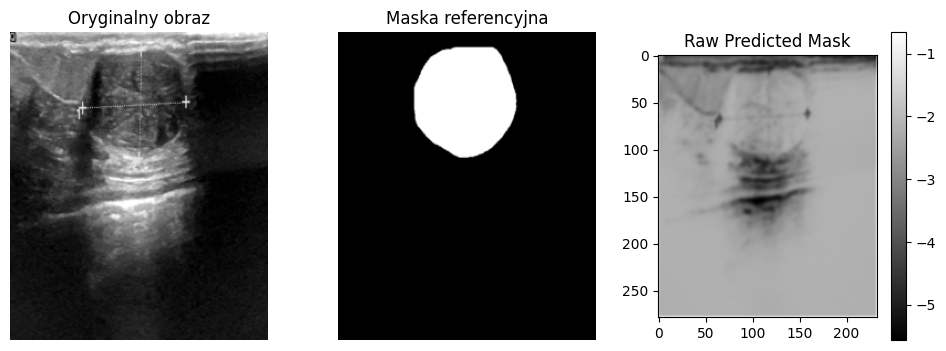

<Figure size 640x480 with 0 Axes>

In [ ]:
from sklearn.model_selection import train_test_split
from torchvision import transforms
from torch.utils.data import DataLoader

# Scieżka folderu danych USG
data_dir = 'dataset'

device = 'cpu'
if torch.backends.mps.is_available():
    device = 'mps'
elif torch.cuda.is_available():
    device = 'gpu'

print(f"Wybrany hardware obliczeniowy: {str.upper(device)}")

# Augmentacja, jeśli chcemy stosować 
augmentation = Augmentation(rotation=15, scale=(0.9, 1.1), flip_prob=0.5)

# Przekształcenie obrazów
transform = transforms.Compose([
    transforms.Resize((279, 233)),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float32)
])

# Ładowanie zbioru danych
dataset = BUSIDataset(root_dir=data_dir, transform=transform, augment=None)

# Podział na trening i walidację
train_data, val_data = train_test_split(dataset, test_size=0.2, random_state=22)

# Obiekty DataLoader
train_loader = DataLoader(train_data, batch_size=4, shuffle=True)
val_loader = DataLoader(val_data, batch_size=4, shuffle=False)

dataloaders = {'train': train_loader, 'eval': val_loader}

# Definicja modelu UNet
model = UNet(device=device)

# Funkcja kosztu i optymalizator
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

# Trening
num_epochs = 100
for epoch in range(num_epochs):
    print(f"Epoka {epoch + 1}/100")
    
    # Trening
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
    print(f"Średnia strata treningowa: {train_loss:.4f}")
    
    # Walidacja
    val_loss = validate_one_epoch(model, val_loader, criterion, device)
    print(f"Średnia strata walidacyjna: {val_loss:.4f}")
    
    # Wyświetlenie przykładowych predykcji po każdej epoce
    visualize_predictions(model, val_loader, device, epoch)

    trained_model = model

    # Zapisujemy nasz trenowany model co 10-tą epokę
    if epoch % 10 == 0:
        save_checkpoint(trained_model, optimizer, 
                        epoch, filename=f"model_checkpoint_{epoch}.pth")